In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv

# Plotting defaults (optional but nice)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 120

# Reproducibility
np.random.seed(42)

# Training/config
LAMBDA_TC = 0.1
TOTAL_TIMESTEPS = 50_000  # increase later for better training
MODEL_PATH = "ppo_hedge_agent"

In [2]:
def simulate_gbm_paths(S0=100.0, mu=0.05, sigma=0.2, T=0.25, dt=1/252,
                       n_paths=1, transaction_cost=5.0, rebal_freq=1):
    n_steps = int(np.round(T / dt))
    times = np.linspace(0.0, T, n_steps + 1)
    rng = np.random.default_rng()
    shocks = rng.standard_normal((n_steps, n_paths))

    prices = np.empty((n_steps + 1, n_paths))
    prices[0] = S0
    costs = np.zeros(n_paths)

    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    cost_rate = transaction_cost * 1e-4

    for step in range(1, n_steps + 1):
        prev_prices = prices[step - 1]
        z = shocks[step - 1]
        current_prices = prev_prices * np.exp(drift + diffusion * z)
        prices[step] = current_prices
        if step % rebal_freq == 0:
            costs += current_prices * cost_rate

    return pd.DataFrame(prices, index=times, columns=[f"path_{i}" for i in range(n_paths)]), pd.Series(costs)

In [3]:
from gymnasium import spaces

class MarketEnv(gym.Env):
    """GBM market env with transaction costs; observation=[price, t_index]."""

    def __init__(self, S0=100, mu=0.05, sigma=0.2, T=0.25, dt=1/252, transaction_cost=5.0):
        super().__init__()
        self.S0, self.mu, self.sigma, self.T, self.dt, self.transaction_cost = S0, mu, sigma, T, dt, transaction_cost

        # Action = hedge ratio in [-1, 1]
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        # Observation = [current_price, discrete_time_index]
        self.observation_space = spaces.Box(low=0, high=np.finfo(np.float32).max, shape=(2,), dtype=np.float32)

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        self.price_path, _ = simulate_gbm_paths(S0=self.S0, mu=self.mu, sigma=self.sigma,
                                                T=self.T, dt=self.dt, n_paths=1,
                                                transaction_cost=self.transaction_cost, rebal_freq=1)
        self.prices = self.price_path.iloc[:, 0].values
        self.pnl = 0.0
        self.prev_action = 0.0

        obs = np.array([self.prices[self.t], self.t], dtype=np.float32)
        return obs, {}

    def step(self, action):
        action = float(action[0])
        self.t += 1

        S_prev, S_now = self.prices[self.t - 1], self.prices[self.t]
        dS = S_now - S_prev

        pnl_step = action * dS
        tc = abs(action - self.prev_action) * S_now * self.transaction_cost * 1e-4
        reward = pnl_step - tc

        self.pnl += reward
        self.prev_action = action

        terminated = self.t >= len(self.prices) - 1
        truncated = False

        obs = np.array([S_now, self.t], dtype=np.float32)
        info = {"pnl": self.pnl, "transaction_cost": tc}
        return obs, reward, terminated, truncated, info

In [4]:
class VarianceAdjustedRewardWrapper(gym.Wrapper):
    def __init__(self, env, lambda_tc=0.1):
        super().__init__(env)
        self.lambda_tc = lambda_tc
        self.pnl_history = []

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.pnl_history.clear()
        return obs, info

    def step(self, action):
        obs, _raw_reward, terminated, truncated, info = self.env.step(action)
        pnl = float(info.get("pnl", 0.0))
        tc = float(info.get("transaction_cost", 0.0))
        self.pnl_history.append(pnl)
        pnl_var = np.var(self.pnl_history, ddof=1) if len(self.pnl_history) > 1 else 0.0
        reward = -pnl_var - self.lambda_tc * tc
        return obs, reward, terminated, truncated, info


class RewardLoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.timesteps, self.episode_rewards = [], []

    def _on_training_start(self):
        self._episode_buffers = np.zeros(self.training_env.num_envs)

    def _on_step(self):
        rewards, dones = self.locals["rewards"], self.locals["dones"]
        self._episode_buffers += rewards
        for i, done in enumerate(dones):
            if done:
                self.timesteps.append(self.num_timesteps)
                self.episode_rewards.append(self._episode_buffers[i])
                self._episode_buffers[i] = 0.0
        return True

In [5]:
def make_env():
    base = MarketEnv(T=0.25)  # ~63 trading days for quick episodes
    return VarianceAdjustedRewardWrapper(base, lambda_tc=LAMBDA_TC)

vec_env = DummyVecEnv([make_env])
callback = RewardLoggingCallback()

model = PPO("MlpPolicy", vec_env, learning_rate=3e-4, n_steps=1024, batch_size=64, verbose=1)
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback)
model.save(MODEL_PATH)
print(f"✅ Saved PPO policy to {MODEL_PATH}.zip")

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 8814 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 4679         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0032070463 |
|    clip_fraction        | 0.02         |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | -0.000813    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.14e+04     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00161     |
|    std                  | 0.994        |
|    value_loss           | 1.33e+04     |

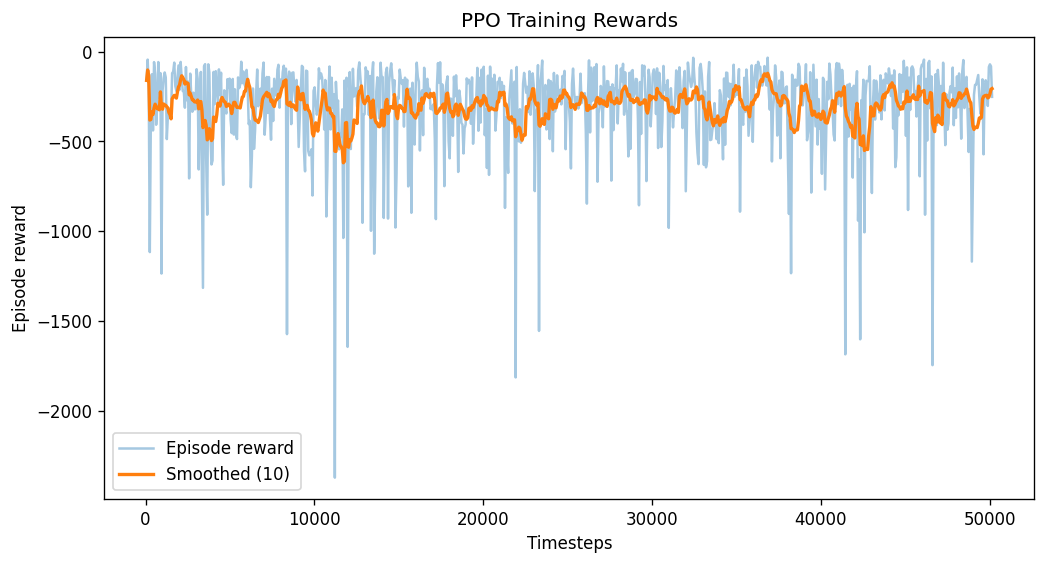

In [6]:
if callback.timesteps:
    reward_series = pd.Series(callback.episode_rewards, index=callback.timesteps)
    smoothed = reward_series.rolling(window=10, min_periods=1).mean()

    plt.figure()
    plt.plot(reward_series.index, reward_series.values, alpha=0.4, label="Episode reward")
    plt.plot(smoothed.index, smoothed.values, linewidth=2, label="Smoothed (10)")
    plt.title("PPO Training Rewards")
    plt.xlabel("Timesteps")
    plt.ylabel("Episode reward")
    plt.legend()
    plt.show()
else:
    print("⚠️ No episodes completed. Reduce T or increase TOTAL_TIMESTEPS.")

In [7]:
loaded = PPO.load(MODEL_PATH)
env = make_env()
obs, info = env.reset()
done = False
while not done:
    action, _ = loaded.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
print("✅ Model ran one episode. Final PnL:", info["pnl"])

✅ Model ran one episode. Final PnL: 6.301908177729178


PPO episodes collected: 5
Random episodes collected: 5


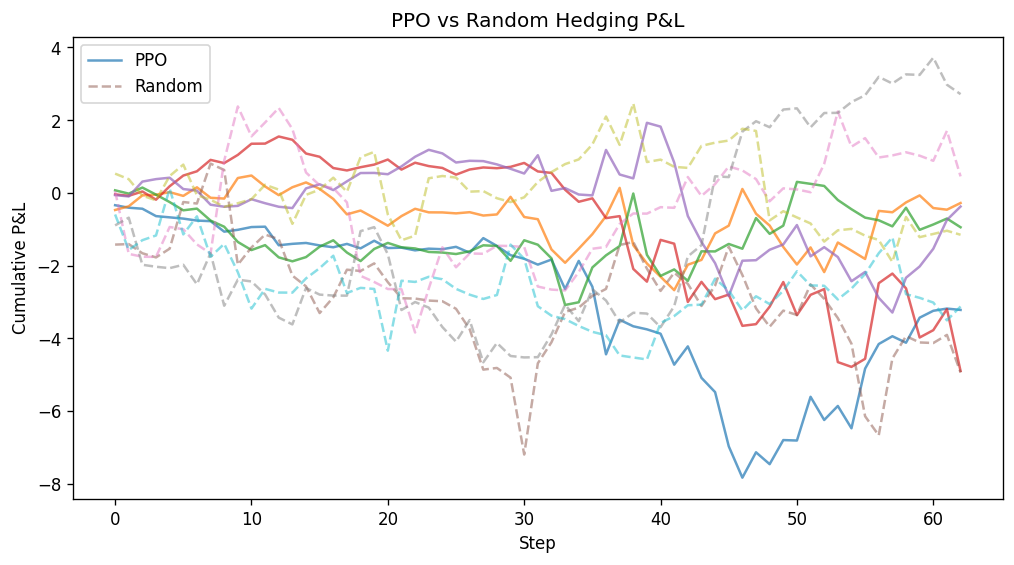

In [8]:
def evaluate_random(env_fn, n_episodes=5):
    ep_pnls = []
    for _ in range(n_episodes):
        e = env_fn()
        obs, info = e.reset()
        done, ep_pnl = False, []
        while not done:
            act = e.action_space.sample()
            obs, reward, terminated, truncated, info = e.step(act)
            ep_pnl.append(info["pnl"])
            done = terminated or truncated
        ep_pnls.append(ep_pnl)
    return ep_pnls

# PPO episodes
ppo_pnls = []
for _ in range(5):
    e = make_env()
    obs, info = e.reset()
    done, ep_pnl = False, []
    while not done:
        a, _ = loaded.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = e.step(a)
        ep_pnl.append(info["pnl"])
        done = terminated or truncated
    ppo_pnls.append(ep_pnl)

# Random episodes
random_pnls = evaluate_random(make_env, n_episodes=5)

print("PPO episodes collected:", len(ppo_pnls))
print("Random episodes collected:", len(random_pnls))

plt.figure()
for pnl in ppo_pnls:
    plt.plot(pnl, alpha=0.7, label="PPO" if "PPO" not in plt.gca().get_legend_handles_labels()[1] else "")
for pnl in random_pnls:
    plt.plot(pnl, alpha=0.5, linestyle="--", label="Random" if "Random" not in plt.gca().get_legend_handles_labels()[1] else "")
plt.legend()
plt.title("PPO vs Random Hedging P&L")
plt.xlabel("Step")
plt.ylabel("Cumulative P&L")
plt.show()

PPO Agent:
  Mean final PnL = -1.94
  Std final PnL  = 2.04
  Sharpe approx  = -0.95

Random Baseline:
  Mean final PnL = -1.21
  Std final PnL  = 2.99
  Sharpe approx  = -0.40



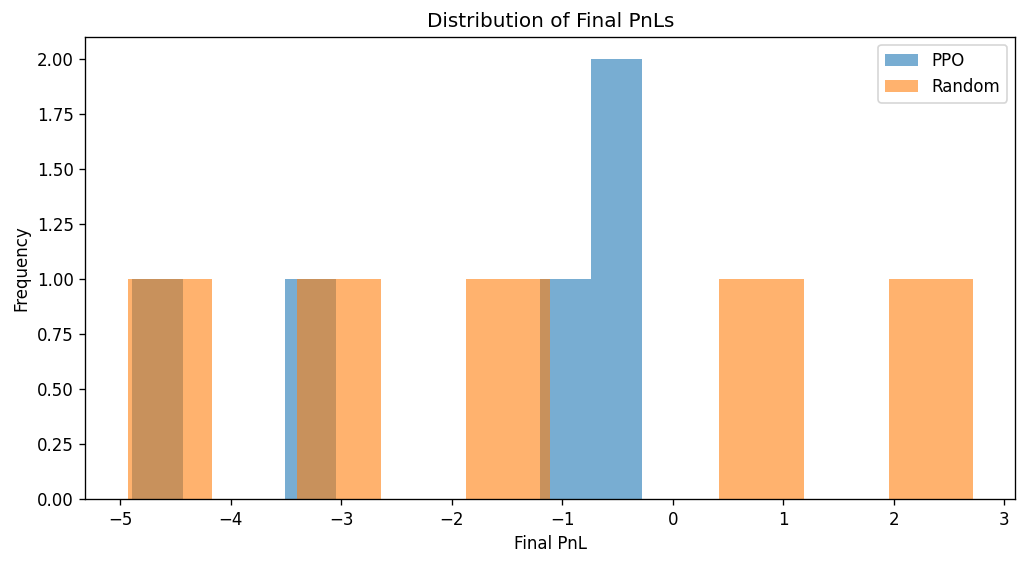

In [9]:
import numpy as np

def summarize_pnls(pnl_list, label):
    final_pnls = [ep[-1] for ep in pnl_list if len(ep) > 0]
    mean_pnl = np.mean(final_pnls)
    std_pnl = np.std(final_pnls, ddof=1)
    sharpe = mean_pnl / std_pnl if std_pnl > 0 else np.nan
    print(f"{label}:")
    print(f"  Mean final PnL = {mean_pnl:.2f}")
    print(f"  Std final PnL  = {std_pnl:.2f}")
    print(f"  Sharpe approx  = {sharpe:.2f}\n")
    return final_pnls

ppo_final = summarize_pnls(ppo_pnls, "PPO Agent")
rand_final = summarize_pnls(random_pnls, "Random Baseline")

plt.hist(ppo_final, bins=10, alpha=0.6, label="PPO")
plt.hist(rand_final, bins=10, alpha=0.6, label="Random")
plt.title("Distribution of Final PnLs")
plt.xlabel("Final PnL")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [10]:
import pickle

with open("ppo_random_pnls.pkl", "wb") as f:
    pickle.dump({"ppo": ppo_pnls, "random": random_pnls}, f)

print("✅ Saved PPO and Random PnLs to ppo_random_pnls.pkl")

✅ Saved PPO and Random PnLs to ppo_random_pnls.pkl
